In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, GRU,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving temp.json to temp.json


In [ ]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [ ]:
data = load_doc('temp.json')

In [ ]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [ ]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

,questions,labels
0,What does it mean to have a mental illness?,definition
1,What is mental health illness,definition
2,Describe mental health illness,definition
3,Who does mental illness affect?,affects_whom
4,Who is affected by mentall illness,affects_whom
5,What causes mental illness?,what_causes
6,What leads to mental illness?,what_causes
7,how does one get mentally ill?,what_causes
8,Can people with mental illness recover?,recover
9,Is it possible to recover from mental illness,recover


In [ ]:
df1.labels.value_counts(sort=False)

professional_types    2
recover               2
affects_whom          2
steps                 2
find_help             2
treatment_tips        2
definition            3
what_causes           3
treatement_options    2
right_professional    2
Name: labels, dtype: int64

In [ ]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


In [ ]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [ ]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [ ]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [ ]:
print(vocab.most_common(20))

[('mental', 14), ('what', 9), ('to', 9), ('illness', 9), ('health', 8), ('how', 7), ('professional', 6), ('is', 4), ('the', 4), ('find', 4), ('doe', 3), ('who', 3), ('can', 3), ('recover', 3), ('are', 3), ('treatment', 3), ('it', 2), ('have', 2), ('one', 2), ('symptom', 2)]


In [ ]:
vocab_size = len(vocab)
vocab_size

62

In [ ]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['who doe mental illness affect',
 'what doe it mean to have mental illness',
 'how to find mental health professional for myself',
 'what is the difference between mental health professional',
 'can people with mental illness recover',
 'how can find mental health professional right myself',
 'know someone who appears to have such symptom',
 'what treatment option are available',
 'how to become involved in treatment',
 'what cause mental illness']

In [ ]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [ ]:
train_index = [i for i in df1.index if i not in test_index]

In [ ]:
' '.join(list(vocab.keys()))

'what doe it mean to have mental illness is health describe who affect affected by mentall cause lead how one get mentally ill can people with recover possible from know someone appears such symptom are the step be followed incase of find professional for myself treatment option available become involved in should keep mind if begin difference between different type present right'

In [ ]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [ ]:
X,vocab_size = encoder(df1,'questions')

In [ ]:
vocab_size

63

In [ ]:
df_encoded = pd.DataFrame(X)

In [ ]:
df_encoded['labels'] = df1.labels
df_encoded


,0,1,2,3,4,5,6,7,8,9,labels
0,2,11,17,25,3,18,1,4,0,0,definition
1,2,8,1,5,4,0,0,0,0,0,definition
2,26,1,5,4,0,0,0,0,0,0,definition
3,12,11,1,4,27,0,0,0,0,0,affects_whom
4,12,8,28,29,30,4,0,0,0,0,affects_whom
5,2,31,1,4,0,0,0,0,0,0,what_causes
6,2,32,3,1,4,0,0,0,0,0,what_causes
7,6,11,19,33,34,35,0,0,0,0,what_causes
8,13,36,37,1,4,14,0,0,0,0,recover
9,8,17,38,3,14,39,1,4,0,0,recover


In [ ]:
for i in range(0,2):
    dt = [0]*10
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {10:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {10:'labels'}),ignore_index=True)

In [ ]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,9,labels
19,2,15,9,60,61,21,1,5,7,62,professional_types
20,6,13,10,1,5,7,24,22,0,0,right_professional
21,6,3,10,9,24,1,5,7,0,0,right_professional
22,0,0,0,0,0,0,0,0,0,0,confused
23,0,0,0,0,0,0,0,0,0,0,confused


In [ ]:
train_index.append(22)

In [ ]:
test_index.append(23)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [ ]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([ 2,  2,  2,  0,  0, 10, 10, 10,  5,  5,  7,  7,  3,  3,  8,  8,  9,
        9,  4,  4,  6,  6,  1,  1])

In [ ]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'affects_whom': 0,
 'confused': 1,
 'definition': 2,
 'find_help': 3,
 'professional_types': 4,
 'recover': 5,
 'right_professional': 6,
 'steps': 7,
 'treatement_options': 8,
 'treatment_tips': 9,
 'what_causes': 10}

In [ ]:
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


In [ ]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,2
1,It is estimated that mental illness affects 1 ...,0
2,Symptoms of mental health disorders vary depen...,10
3,"When healing from mental illness, early identi...",5
4,Although this website cannot substitute for pr...,7


In [ ]:
df2.to_csv('response.csv',index=False)

In [ ]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [ ]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [ ]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [ ]:
y_train[0].shape,y_test[0].shape

((11,), (11,))

In [ ]:
X_train.shape

(13, 10)

In [ ]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 11

In [ ]:
max_length

10

In [ ]:
def define_model(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(GRU(500))
    model3.add(Dense(11, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    plot_model(model3, to_file='model_3.png', show_shapes=True)
    return model3

In [ ]:
def define_model_k(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model_3.png', show_shapes=True)
    return model

In [ ]:
model_GRU_8=define_model(vocab_size,max_length)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           18900     
_________________________________________________________________
gru (GRU)                    (None, 500)               1203000   
_________________________________________________________________
dense (Dense)                (None, 11)                5511      
Total params: 1,227,411
Trainable params: 1,227,411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_k_9=define_model_k(vocab_size,max_length)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 300)           18900     
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 11)                187       
Total params: 24,175
Trainable params: 24,175
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_k_9.fit(X_train,y_train, epochs=35,validation_data=(X_test,y_test))

Epoch 1/35
1/1 [==============================] - 1s 1s/step - loss: 2.3991 - accuracy: 0.0000e+00 - val_loss: 2.3980 - val_accuracy: 0.0909
Epoch 2/35
1/1 [==============================] - 0s 67ms/step - loss: 2.3944 - accuracy: 0.1538 - val_loss: 2.3968 - val_accuracy: 0.0909
Epoch 3/35
1/1 [==============================] - 0s 66ms/step - loss: 2.3905 - accuracy: 0.1538 - val_loss: 2.3955 - val_accuracy: 0.0909
Epoch 4/35
1/1 [==============================] - 0s 61ms/step - loss: 2.3855 - accuracy: 0.1538 - val_loss: 2.3940 - val_accuracy: 0.0909
Epoch 5/35
1/1 [==============================] - 0s 63ms/step - loss: 2.3800 - accuracy: 0.1538 - val_loss: 2.3926 - val_accuracy: 0.0909
Epoch 6/35
1/1 [==============================] - 0s 63ms/step - loss: 2.3742 - accuracy: 0.1538 - val_loss: 2.3913 - val_accuracy: 0.0909
Epoch 7/35
1/1 [==============================] - 0s 58ms/step - loss: 2.3682 - accuracy: 0.1538 - val_loss: 2.3899 - val_accuracy: 0.0909
Epoch 8/35
1/1 [=========

In [ ]:
history = model_GRU_8.fit(X_train,y_train, epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 2.4009 - accuracy: 0.0769 - val_loss: 2.3938 - val_accuracy: 0.0909
Epoch 2/20
1/1 [==============================] - 0s 171ms/step - loss: 2.3422 - accuracy: 0.3077 - val_loss: 2.3967 - val_accuracy: 0.0909
Epoch 3/20
1/1 [==============================] - 0s 180ms/step - loss: 2.2869 - accuracy: 0.3077 - val_loss: 2.4079 - val_accuracy: 0.0909
Epoch 4/20
1/1 [==============================] - 0s 179ms/step - loss: 2.2302 - accuracy: 0.3077 - val_loss: 2.4318 - val_accuracy: 0.0909
Epoch 5/20
1/1 [==============================] - 0s 173ms/step - loss: 2.1708 - accuracy: 0.3077 - val_loss: 2.4716 - val_accuracy: 0.0909
Epoch 6/20
1/1 [==============================] - 0s 179ms/step - loss: 2.1093 - accuracy: 0.3077 - val_loss: 2.5119 - val_accuracy: 0.0909
Epoch 7/20
1/1 [==============================] - 0s 164ms/step - loss: 2.0400 - accuracy: 0.3077 - val_loss: 2.5114 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [===

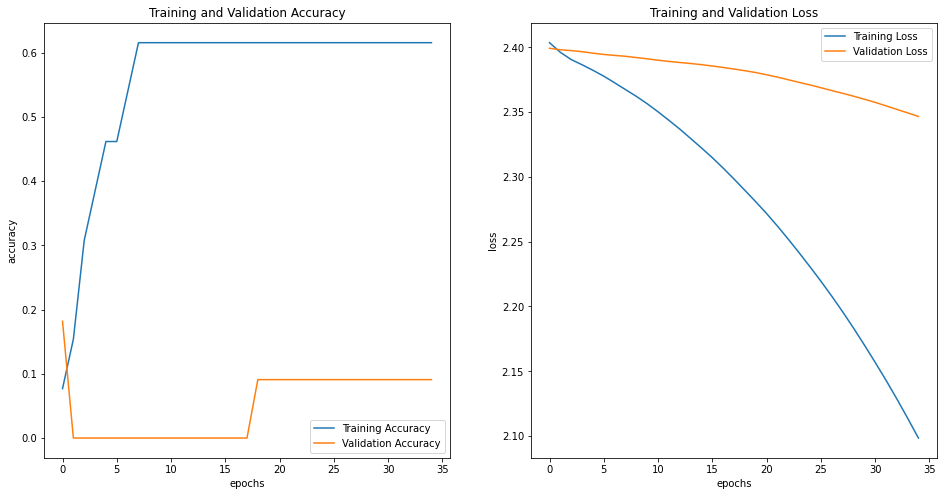

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
[np.argmax(i) for i in model_GRU_8.predict(X_test)][:10]

[10, 5, 6, 6, 10, 6, 5, 10, 0, 2]

In [ ]:
[np.argmax(i) for i in model_k_9.predict(X_test)][:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
[np.argmax(i) for i in y_test][:10]

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
def get_text():
    input_text  = ['How to find the right professional help?']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [ ]:

#load artifacts 
from tensorflow.keras.models import load_model
#model = load_model('model-v1.h5')
import os
model_k_9.save(os.path.join("./dnn/","mpg_model.h5"))
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [ ]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [ ]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [ ]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=10, padding='post')
    return padded

In [ ]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred


In [ ]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [ ]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

In [ ]:
def bot_response(response,):
    print(response)

In [ ]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model_k_9,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.
